In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.path.join("./", "..", ".."))

In [2]:
from Model import *

In [3]:
config_path = './../../configs/vae.json'
import json
from types import SimpleNamespace
config = SimpleNamespace(**json.load(open(config_path, 'r')))

In [4]:
# config

In [5]:
data_path = './../../Data/diabetes/'
config.features_path = data_path + "X.tsv"
config.labels_path = data_path + "y.tsv"
config.model_dir = './../../Models'
config.dataset = "diabetes"

In [6]:
from Model import *

In [7]:
model = Model.Initialize('vae', None, pretrained_path='./../../Models/scvis_diabetes.pt')

Loading the pretrained model...


In [8]:
# import pandas as pd
x = pd.read_csv(config.features_path, sep="\t").to_numpy()
y = pd.read_csv(config.labels_path, sep="\t").to_numpy().tolist()

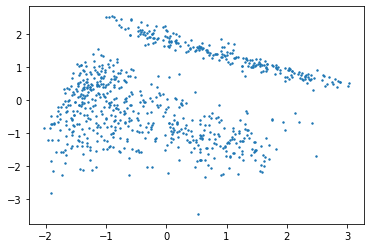

In [9]:
data_rep = model.Encode(x)
import matplotlib.pyplot as plt
plt.scatter(data_rep[:,0], data_rep[:,1], s=2)

In [10]:
from sklearn.cluster import KMeans
num_clusters = 3

kmeans = KMeans(n_clusters = num_clusters).fit(data_rep)

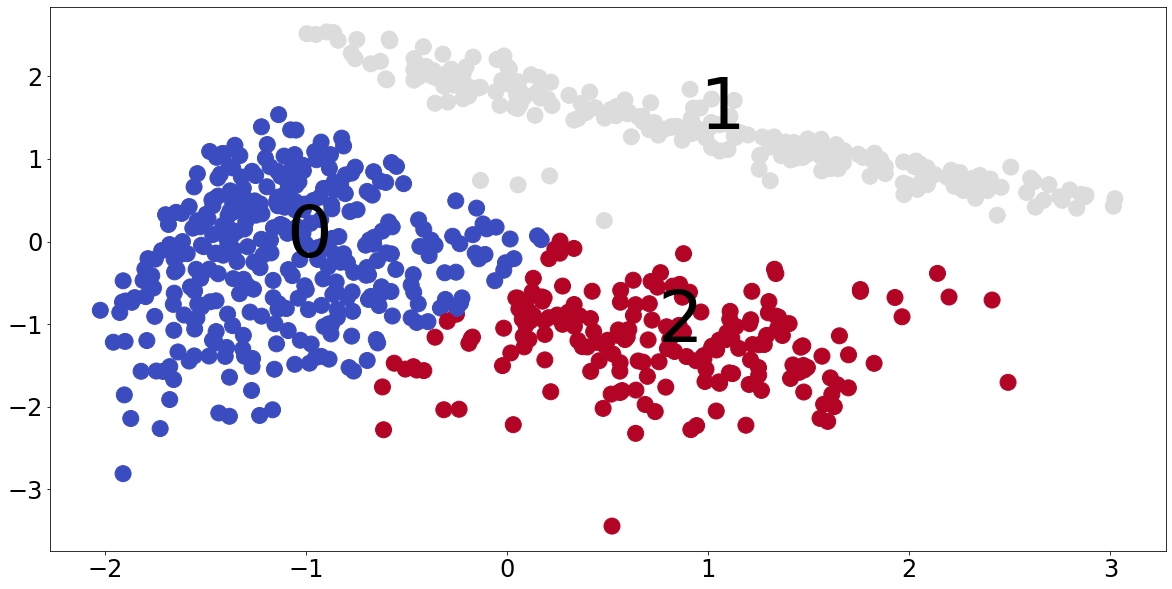

In [11]:
from eldr.plotter.myplot import *
means, centers, indices = plot_groups(x, data_rep.numpy(), num_clusters, kmeans.labels_, name = "./rep.png")

In [12]:
#find the best_epsilon
from eldr.explain.explain_cs import *
epsilon = 0

Explainer = Explain(model, means, centers, use_scaling=False)

epsilons = np.linspace(0, 2.0, num=100).tolist()
for iter_epsilon in epsilons:
    mean_, min_, max_ = Explainer.eval_epsilon(torch.tensor(x), indices, iter_epsilon)
    if mean_ >= 0.95 and min_ >= 0.95 and max_>= 0.95:
        epsilon = iter_epsilon
        break
print(epsilon)

0.24242424242424243


In [13]:
out = np.loadtxt("out.csv", delimiter = ",")
print(out)

#columns: K, TGT_correctness, TGT_coverage, DBM_correctness, DBM_coverage

[[ 1.          0.72229879  0.79451916  0.71019555  0.78557699]
 [ 3.          0.75205094  0.81893773  0.71804186  0.79552372]
 [ 5.          0.75401037  0.81866193  0.72164187  0.81232452]
 [ 7.          0.74992175  0.82291318  0.72396937  0.81273491]
 [ 9.          0.75055849  0.82092546  0.72998199  0.81027308]
 [11.          0.75024012  0.82226955  0.72998199  0.81027308]
 [13.          0.75296349  0.81941873  0.72998199  0.81027308]]


[[ 0.00149899 -0.00211703  0.0009151  -0.32526928  0.00092984  0.00048088
   0.00041575  0.23883486]
 [ 0.00086255 -0.00170118  0.00300016  0.01862227  0.00179231  0.00341934
   0.00008948  0.41300365]]


./../../eldr/plotter/myplot.py:106: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  ax.cax.colorbar(im)
/home2/tirthankar/miniconda3_1/envs/rajeev3/lib/python3.7/site-packages/mpl_toolkits/axes_grid1/axes_grid.py:46: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid1.colorbar module was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use matplotlib.colorbar instead.
  from .colorbar import Colorbar


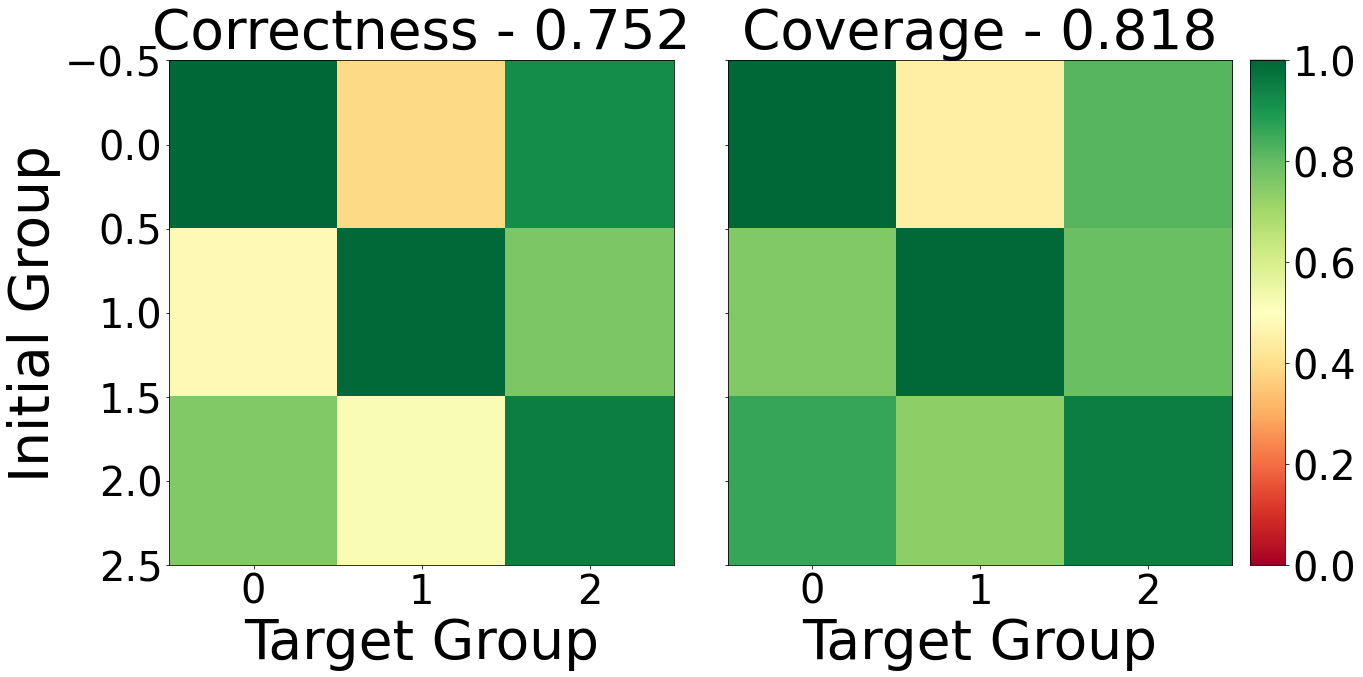

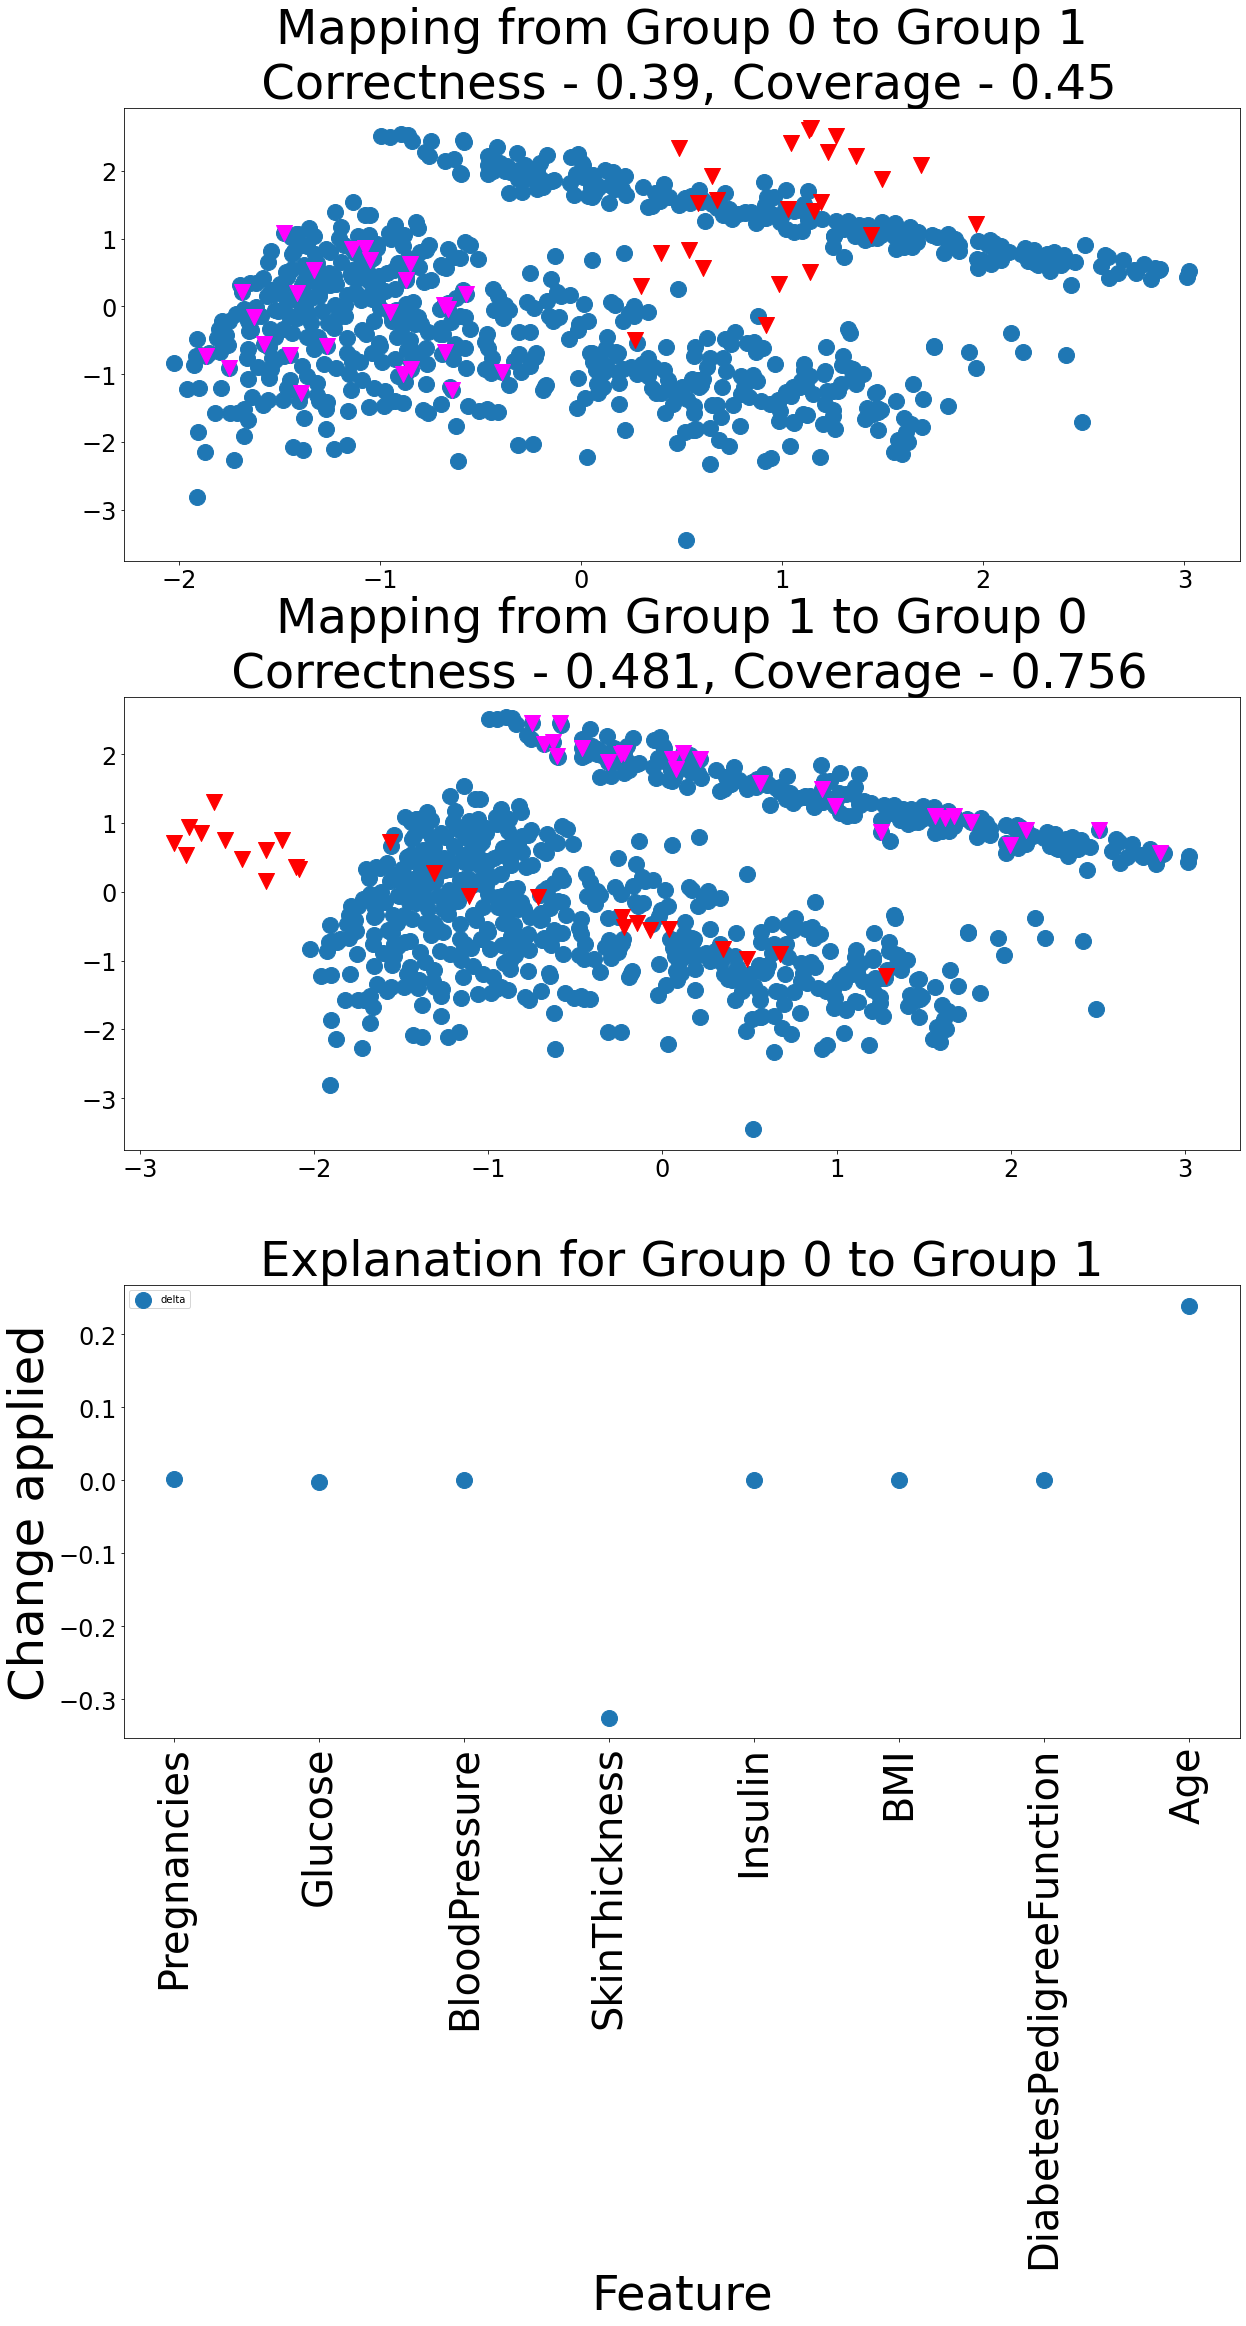

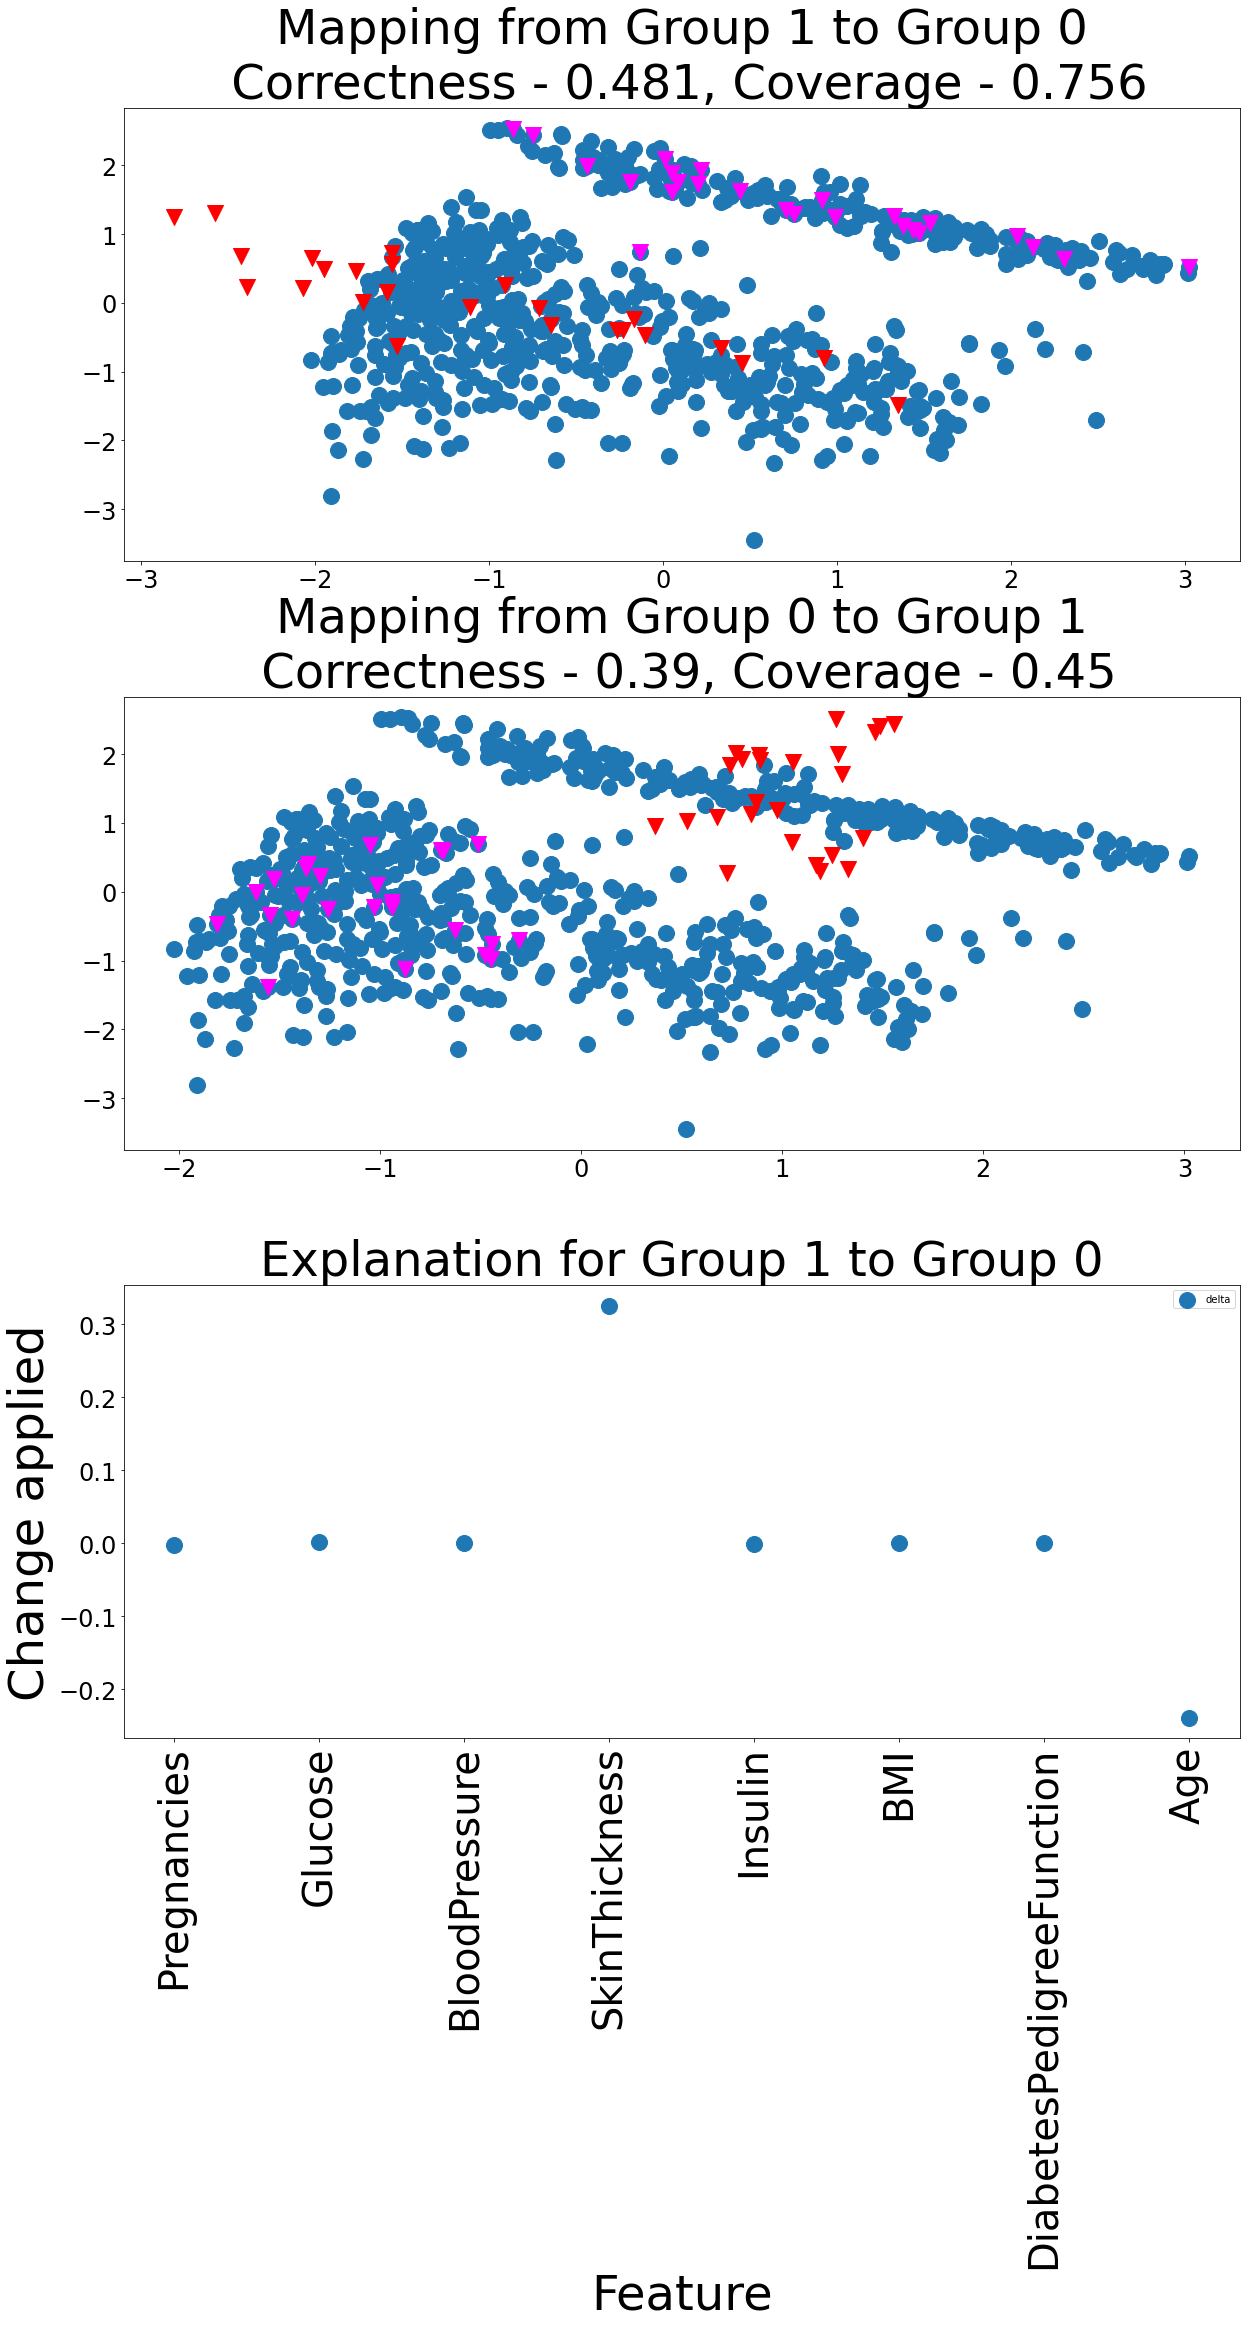

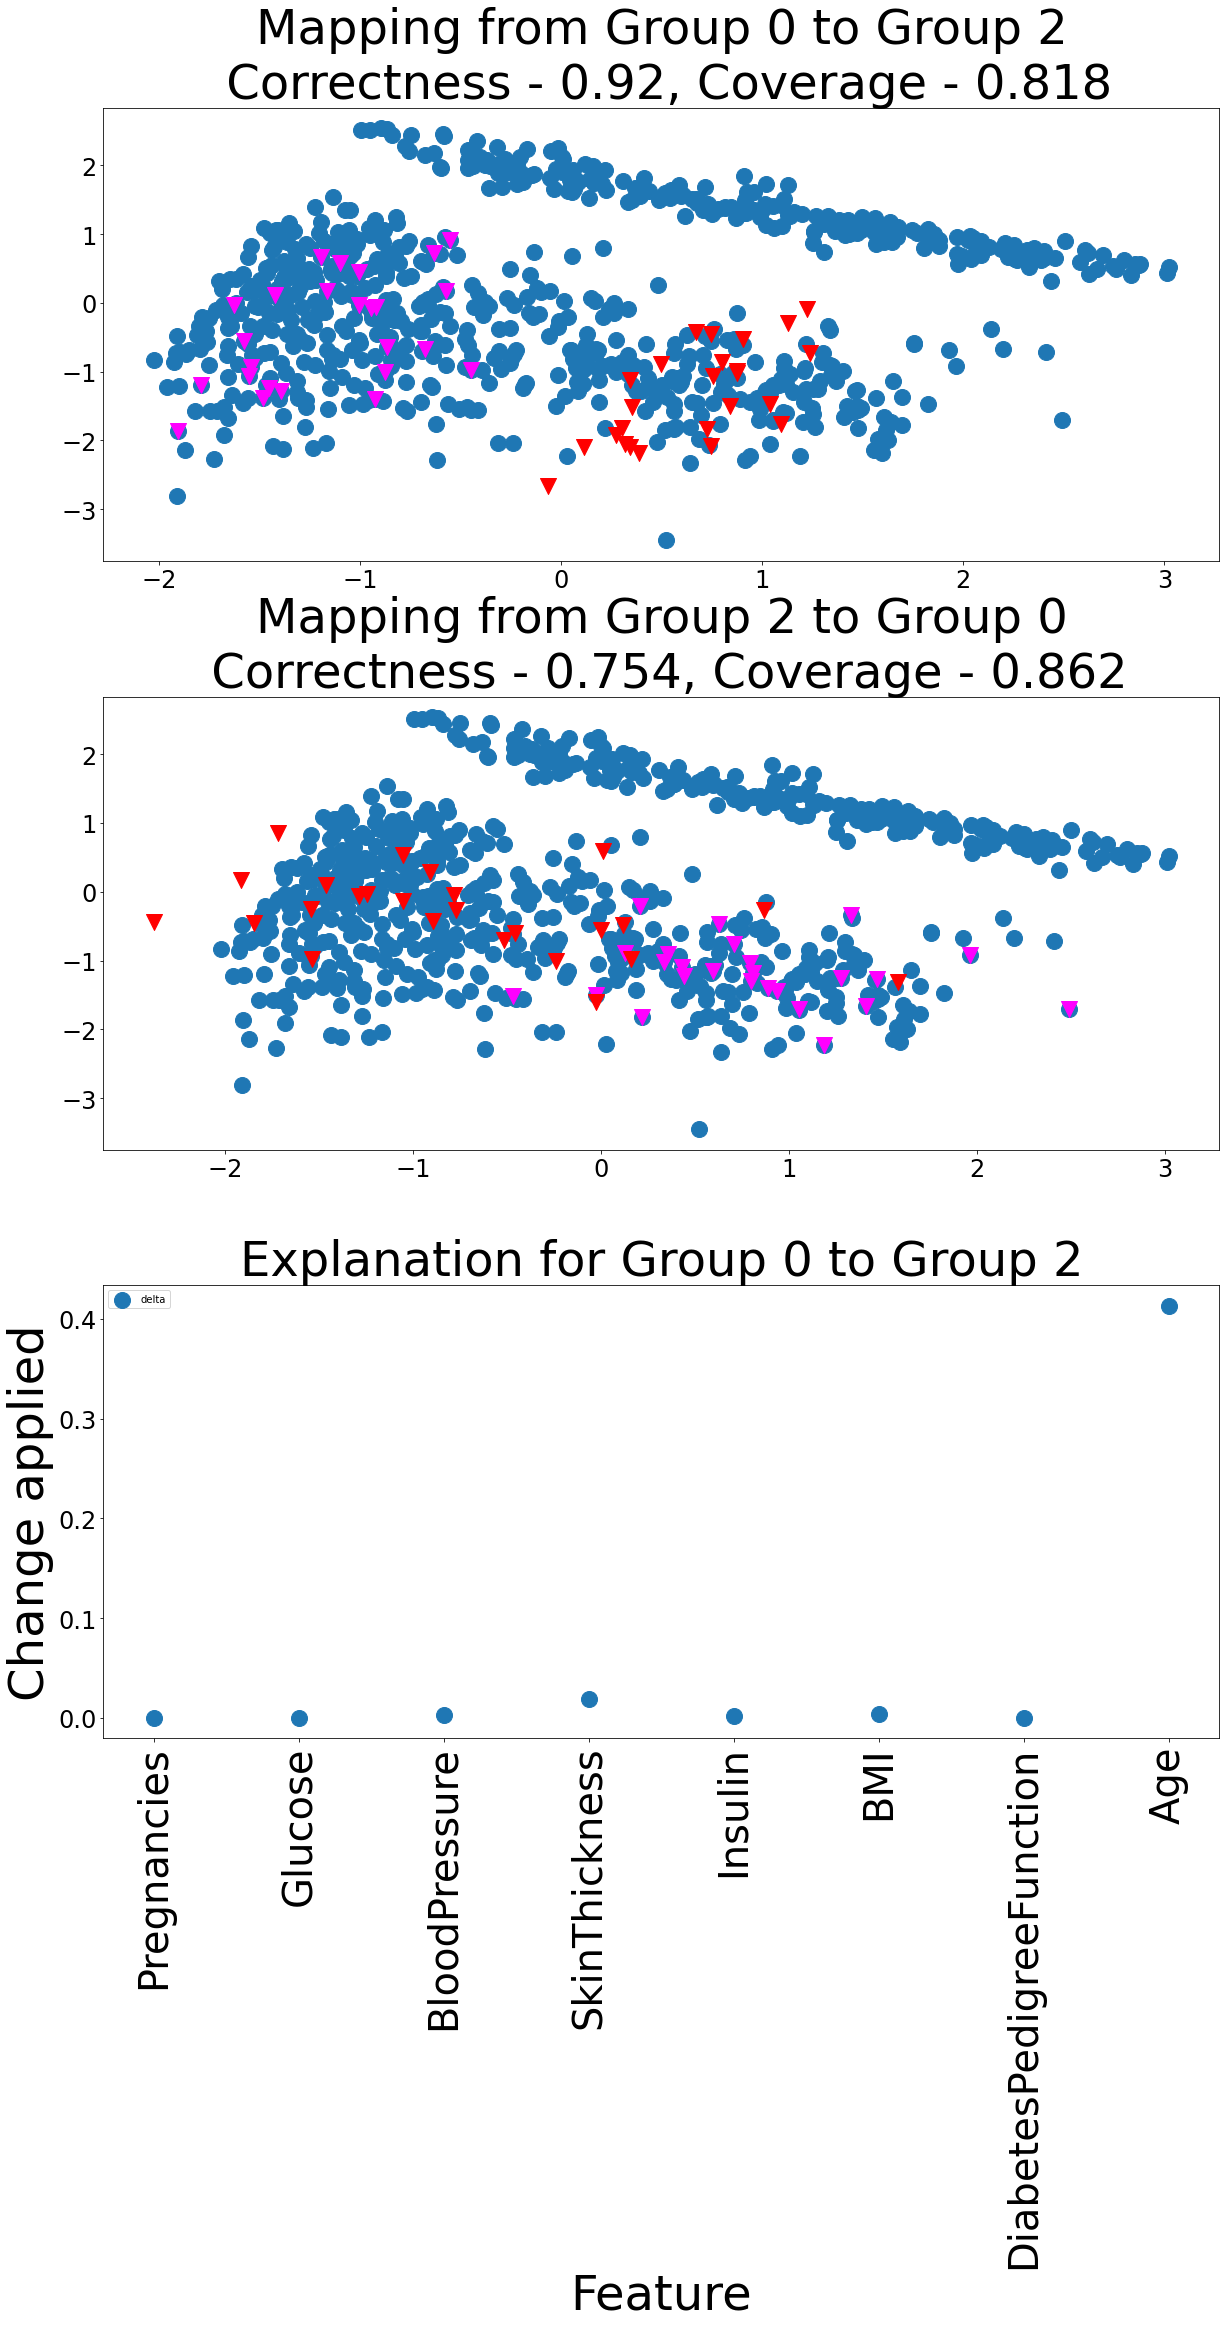

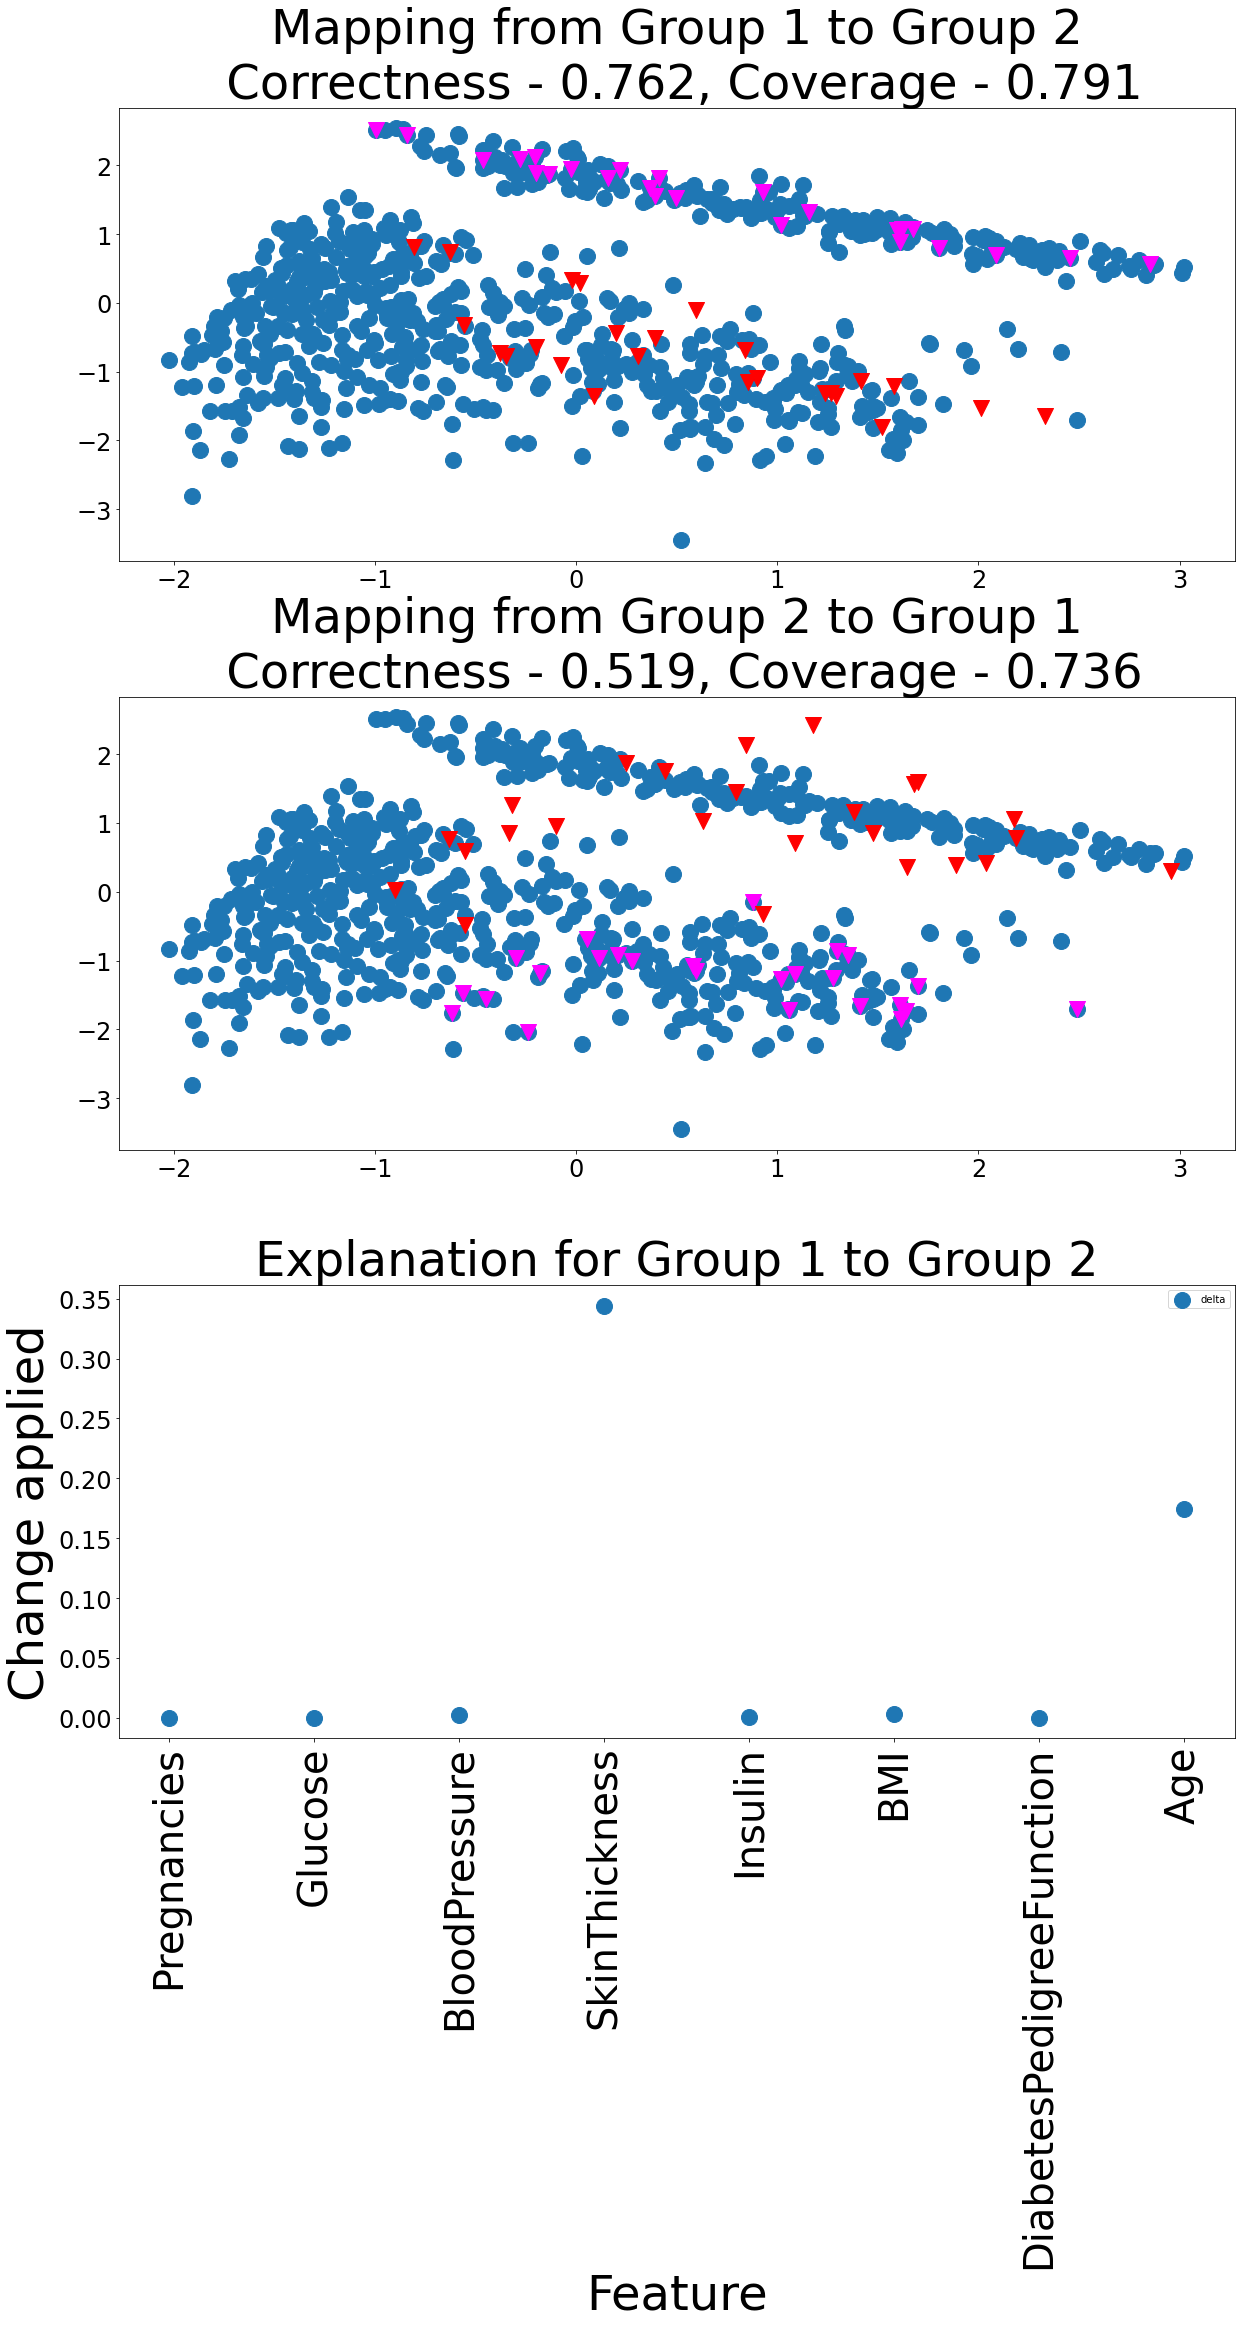

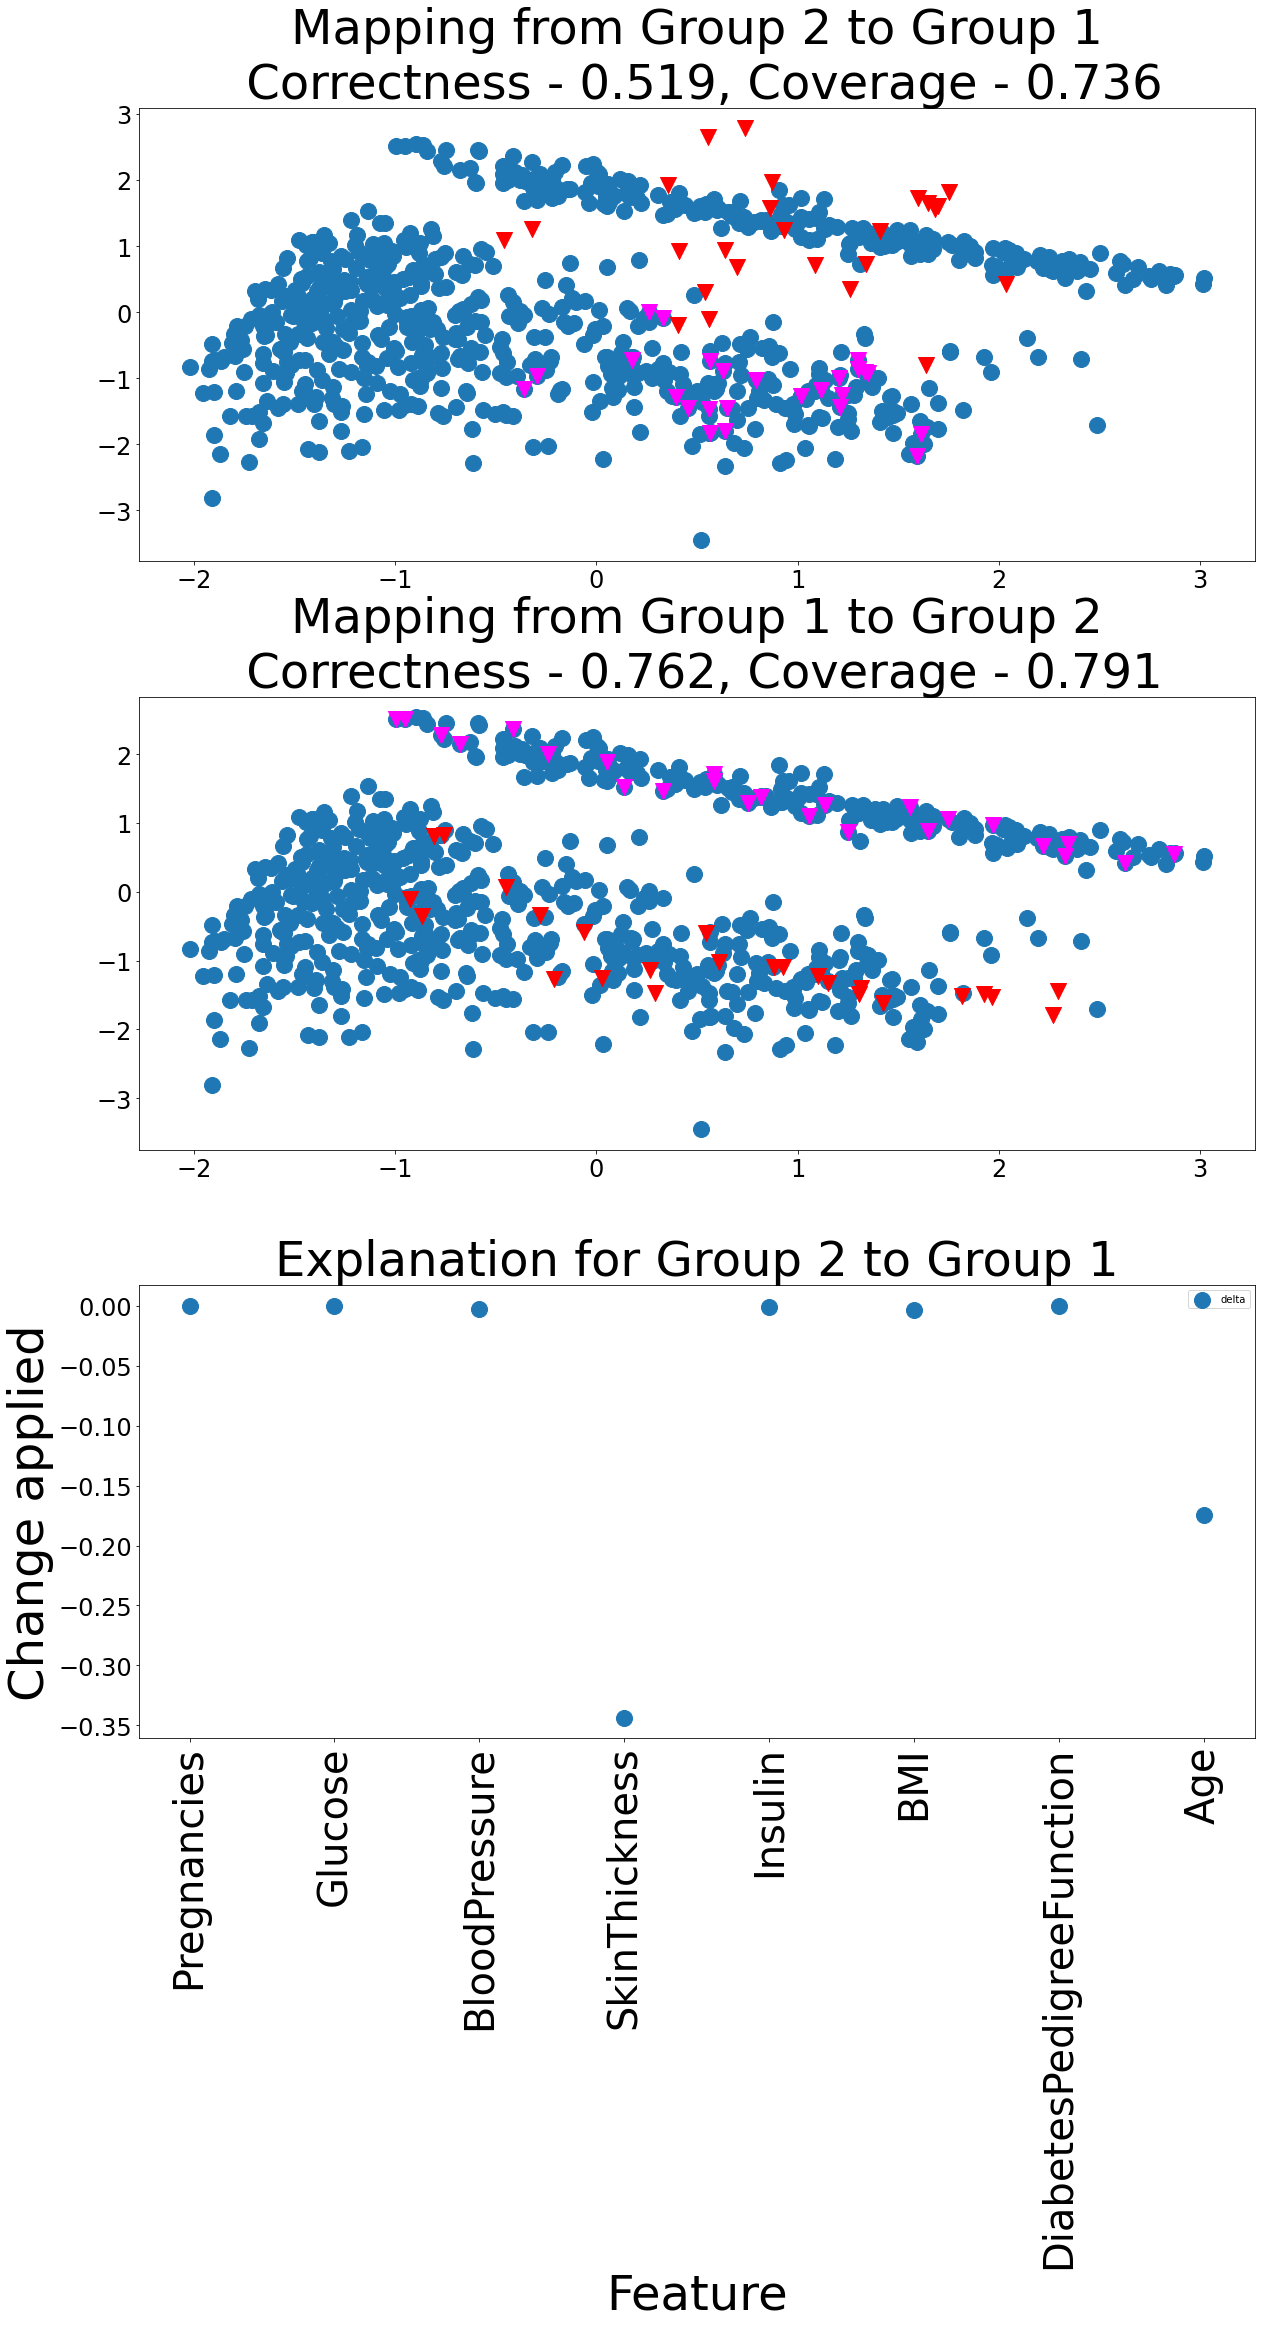

In [14]:
# Evaluate the explanations
from eldr.explain.explain_cs import *
from eldr.plotter.myplot import *
k = 5
epsilon = 0.24
import torch
feature_names = list(pd.read_csv('./../../Data/diabetes/diabetes.csv').columns)[:-1]

deltas_ = np.load("./deltas/deltas" + str(k) + ".npy")
np.set_printoptions(suppress=True)
print(deltas_)

Explainer = Explain(model, means, centers)

a, b = Explainer.metrics(torch.tensor(x), indices, torch.from_numpy(deltas_), epsilon, k = k)

plot_metrics(a, b, name = "diabetes-metrics.png")

plot_explanation(model, x, data_rep, indices, deltas_, a, b, 0, 1, k = k, num_points = 25, name = "diabetes-0to1.png", feature_names = feature_names)

plot_explanation(model, x, data_rep, indices, deltas_, a, b, 1, 0, k = k,  num_points = 25, name = "diabetes-1to0.png", feature_names = feature_names)
plot_explanation(model, x, data_rep, indices, deltas_, a, b, 0, 2, k = k, num_points = 25, name = "diabetes-0to2.png", feature_names = feature_names)
plot_explanation(model, x, data_rep, indices, deltas_, a, b, 1, 2, k = k,  num_points = 25, name = "diabetes-1to2.png", feature_names = feature_names)
plot_explanation(model, x, data_rep, indices, deltas_, a, b, 2, 1, k = k,  num_points = 25, name = "diabetes-2to1.png", feature_names = feature_names)

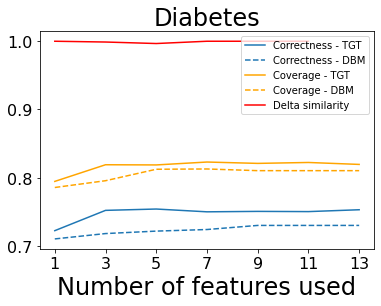

In [64]:
from eldr.misc import load
import matplotlib
matplotlib.rc("xtick", labelsize = 16)
matplotlib.rc("ytick", labelsize = 16)
matplotlib.rc("axes", titlesize = 24)
matplotlib.rc("axes", labelsize = 24)

K = [1, 3, 5, 7, 9, 11, 13]

out_path = './out.csv'
out = np.loadtxt(out_path, delimiter=",")
S_deltas = np.zeros(len(K) - 1)
S_range = []
for c in range(len(K) - 1):
    k_more = K[c]
    k_less = K[c + 1]
    
    d_more = np.load("./deltas/deltas" + str(k_more) + ".npy")
    d_less = np.load("./deltas/deltas" + str(k_less) + ".npy")
    
    res_deltas = np.ones((num_clusters, num_clusters))
    
    for i in range(num_clusters):
        for j in range(num_clusters):
            if i != j:
                e_d_more = load(d_more, k_more, i, j).numpy()
                e_d_less = load(d_less, k_less, i, j).numpy()
                
                res_deltas[i,j] = Explainer.similarity(e_d_more, e_d_less)
    S_deltas[c] = np.mean(res_deltas)
    S_range.append(k_more)

plt.plot(out[:, 0], out[:, 1], c = "C0", label = "Correctness - TGT")
plt.plot(out[:, 0], out[:, 3], ls = "--", c= "C0", label = "Correctness - DBM")
plt.plot(out[:, 0], out[:, 2], c = "orange", label = "Coverage - TGT")
plt.plot(out[:, 0], out[:, 4], ls = "--", color = "orange", label = "Coverage - DBM")
plt.plot(S_range, S_deltas, c = 'red', label='Delta similarity')
plt.xlabel('Number of features used')
plt.title('Diabetes')
plt.xticks(np.arange(1, 15, step=2))
plt.legend()

plt.savefig("diabetes-tradeoff.png", bbox_inches='tight')
plt.show()
plt.close()

#### Classification And Feature Attribution

In [52]:
class_data = []
class_label = []
for i, ind in enumerate(indices):
    class_data.extend(x[ind])
    class_label.extend([i]*len(ind))

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.svm import LinearSVC
X = class_data
y = class_label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=0)
clf = OneVsOneClassifier(LinearSVC(random_state=0)).fit(X_train, y_train)

In [54]:
estimators = clf.estimators_

In [61]:
from sklearn.inspection import permutation_importance
imp = []
for i, clf in enumerate(estimators):
    results = permutation_importance(clf, X, y, scoring='accuracy')
    importance = results.importances_mean
    imp.append(importance)

In [62]:
df = pd.DataFrame(imp, columns = feature_names, dtype = float)
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.002608,0.000782,0.000522,0.309518,0.016428,0.001043,0.000000,0.008866
1,0.068579,0.010169,0.002868,-0.001565,-0.001565,0.002086,0.002086,0.175228
2,0.006258,0.000000,0.001043,-0.313690,-0.026597,-0.001304,0.000782,0.008866


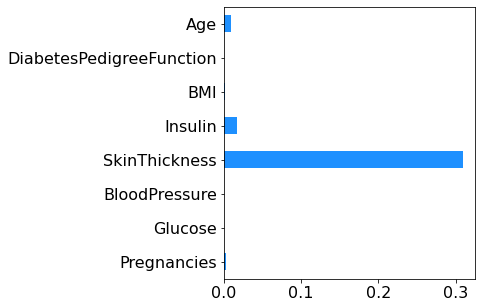

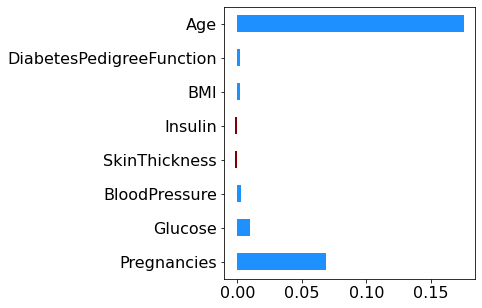

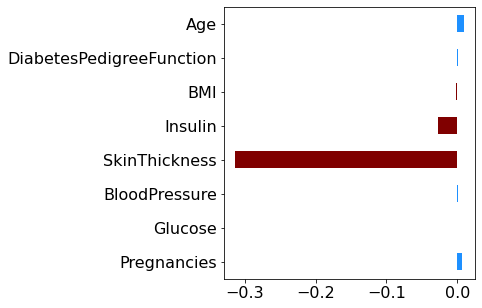

In [63]:
for i in range(len(df)):
    fig = plt.figure(figsize=(4.5,5))
    color = (df.iloc[i] > 0).apply(lambda x: 'dodgerblue' if x else 'maroon')
    df.iloc[i].plot.barh(color=color)
    plt.show()